# CONVOLUTIONAL NEURAL NETWORK (CNN) FOR CASTING PRODUCT QUALITY INSPECTION
Casting is a manufacturing process in which liquid material is poured into a mold to solidify. Many types of defects or unwanted irregularities can occur during this process. The industry has its quality inspection department to remove defective products from the production line, but this is very time consuming since it is carried out manually. Furthermore, there is a chance of misclassifying due to human error, causing rejection of the whole product order.

In this notebook, let us automate the inspection process by training top-view images of a casted submersible pump impeller using a Convolutional Neural Network (CNN) so that it can distinguish accurately between defect from the ok one.

We will break down into several steps:

Load the images and apply the data augmentation technique

Visualize the images

Training with validation: define the architecture, compile the model, model fitting and evaluation

Testing on unseen images

Make a conclusion

In [27]:
#Import Libraries
#As usual, before we begin any analysis and modeling, let's import several necessary libraries to work with the data.
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

In [29]:
IMAGE_DIR = "D:/DS/487456_1300891_bundle_archive/casting_data/casting_data/"
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                shuffle = True,
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",subset = "training", **gen_args)
validation_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",subset = "validation", **gen_args)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.


In [30]:
# test Data
#Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1].
#And the benefits are: Treat all images in the same manner: some images are high pixel range, some are low pixel range. 
#The images are all sharing the same model, weights and learning rate
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "test",**gen_args)

Found 715 images belonging to 2 classes.


In [34]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [53]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

In [54]:
model = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 149, 149, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               663680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [56]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [58]:
STEPS = 150

checkpoint = ModelCheckpoint("D:/DS/487456_1300891_bundle_archive/cnn_casting_inspection_model.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = STEPS,
                    epochs = 25,
                    validation_steps = STEPS,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/25
150/150 [==============================] - 407s 3s/step - loss: 0.6350 - accuracy: 0.6132 - val_loss: 0.5492 - val_accuracy: 0.6994

Epoch 00001: val_loss improved from inf to 0.54919, saving model to cnn_casting_inspection_model.hdf5
Epoch 2/25
150/150 [==============================] - 334s 2s/step - loss: 0.5317 - accuracy: 0.7040 - val_loss: 0.5674 - val_accuracy: 0.7721

Epoch 00002: val_loss did not improve from 0.54919
Epoch 3/25
150/150 [==============================] - 364s 2s/step - loss: 0.4340 - accuracy: 0.7844 - val_loss: 0.4761 - val_accuracy: 0.8046

Epoch 00003: val_loss improved from 0.54919 to 0.47611, saving model to cnn_casting_inspection_model.hdf5
Epoch 4/25
150/150 [==============================] - 389s 3s/step - loss: 0.3278 - accuracy: 0.8482 - val_loss: 0.3209 - val_accuracy: 0.8940

Epoch 00004: val_loss improved from 0.47611 to 0.32086, saving model to cnn_casting_inspection_model.hdf5
Epoch 5/25
150/150 [==============================] - 404s 

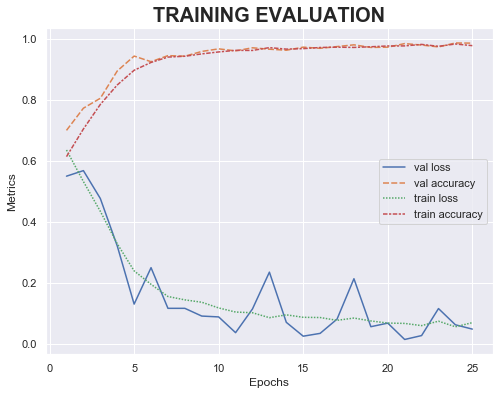

In [59]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

We can conclude that the model is not overfitting the data since both train loss and val loss simultaneously dropped towards zero. Also, both train accuracy and val accuracy increase towards 100%.

# Testing on Unseen Images¶
Our model performs very well on the training and validation dataset which uses augmented images. Now, we test our model performance with unseen and unaugmented images.

In [61]:
best_model = load_model("C:/Users/vr00574274/cnn_casting_inspection_model.hdf5")
y_pred_prob = best_model.predict_generator(generator = test_dataset,
                                           verbose = 1)

12/12 [==============================] - 8s 652ms/step


In [63]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

Predicted       
                     ok defect
Actual ok           262      0
       defect         1    452

In [65]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.9962    1.0000    0.9981       262
           1     1.0000    0.9978    0.9989       453

    accuracy                         0.9986       715
   macro avg     0.9981    0.9989    0.9985       715
weighted avg     0.9986    0.9986    0.9986       715



In [67]:
images, labels = next(iter(test_dataset))

In [68]:
images.shape

(64, 300, 300, 1)

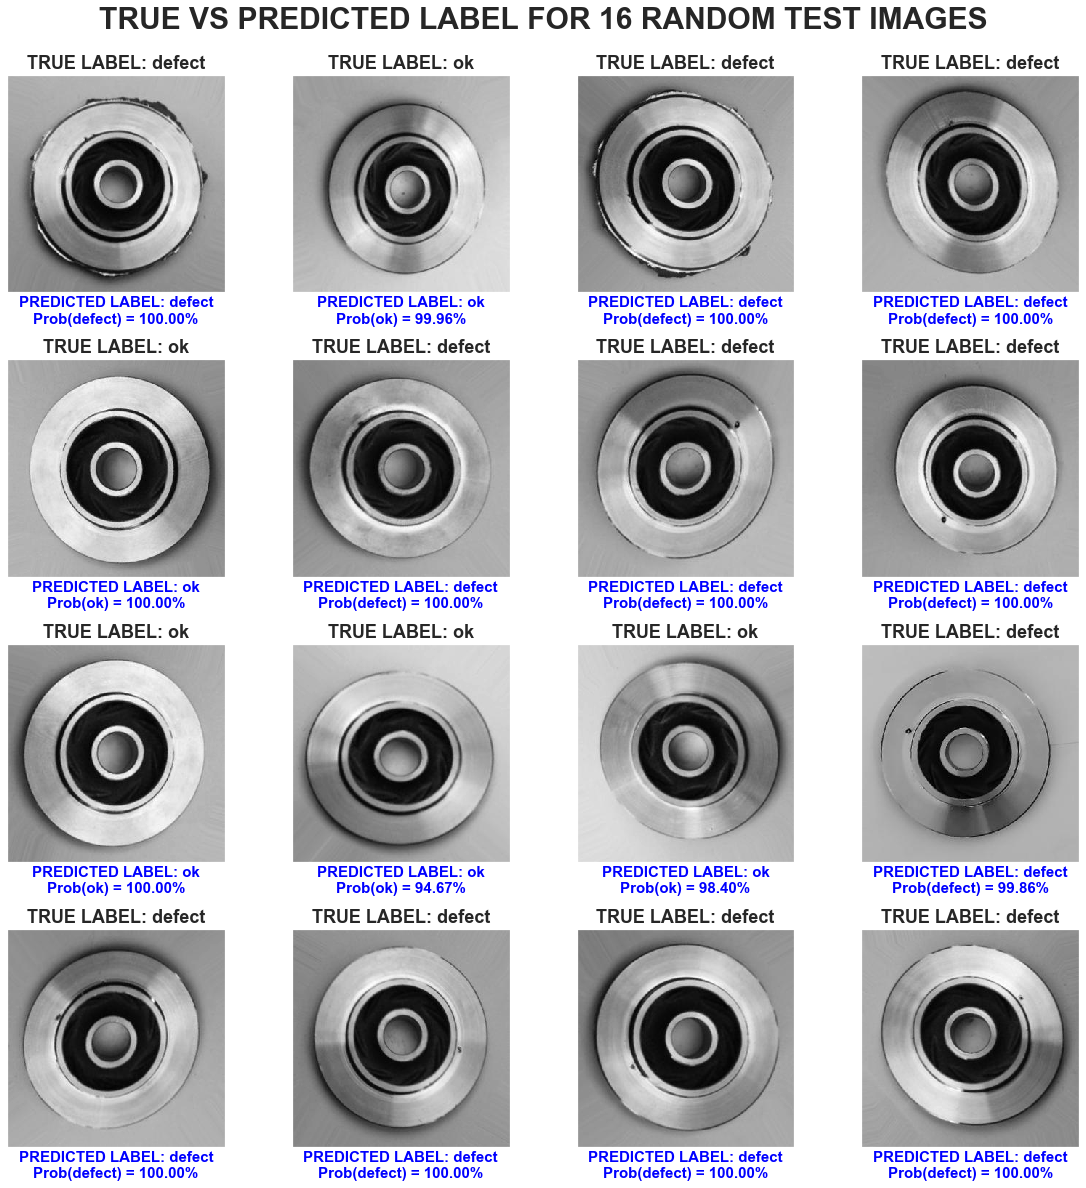

In [69]:
images, labels = next(iter(test_dataset))
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap = "gray")
    true_label = mapping_class[label]
    
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

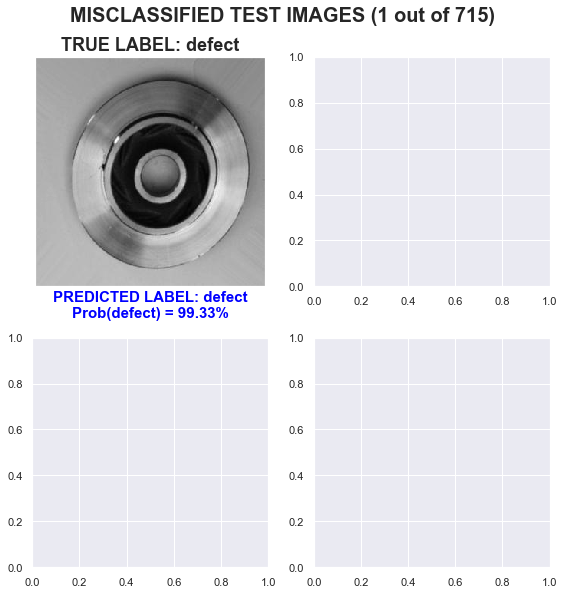

In [70]:
misclassify_pred = np.nonzero(y_pred_class != y_true_class)[0]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_dataset[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE), cmap = "gray")
    
    true_label = mapping_class[labels[image_num]]
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(y_true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

# Conclusion
By using CNN and on-the-fly data augmentation, the performance of our model in training, validation, and test images is almost perfect, reaching 98-99% accuracy and F1 score. We can utilize this model by embedding it into a surveillance camera where the system can automatically separate defective product from the production line. This method surely can reduce human error and human resources on manual inspection, but it still needs supervision from human since the model is not 100% correct at all times.